In [79]:
import numpy as np
import pandas as pd
import datetime as dt
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

%matplotlib inline
sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)


In [2]:
tik_tok_df = pd.read_csv('tiktok_app_reviews.csv')

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
tik_tok_df =tik_tok_df.drop(columns='review_id')

In [4]:
tik_tok_df.head()

,review_text,upvotes,app_version,posted_date
0,It is an excellent solution to finding videos ...,402,21.2.5,2021-09-20 07:50:23
1,Great app works really well so many features s...,67,21.2.5,2021-09-19 23:10:47
2,I down loaded app but didnt work . i love this...,24,21.2.5,2021-09-19 08:59:34
3,IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...,18,21.2.5,2021-09-19 16:34:43
4,Currently it's working good for me except a fe...,232,21.1.41,2021-09-14 06:35:02


In [5]:
tik_tok_df['date'] = pd.to_datetime(tik_tok_df['posted_date'], infer_datetime_format= True).dt.date

In [6]:
split_date= dt.date(2020,1,1)

In [7]:
tik_tok_20_21 = tik_tok_df.loc[tik_tok_df['date']>split_date]

In [8]:
tik_tok_20_21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1937876 entries, 0 to 3646475
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_text  object
 1   upvotes      int64 
 2   app_version  object
 3   posted_date  object
 4   date         object
dtypes: int64(1), object(4)
memory usage: 88.7+ MB


In [9]:
tik_tok_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646476 entries, 0 to 3646475
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_text  object
 1   upvotes      int64 
 2   app_version  object
 3   posted_date  object
 4   date         object
dtypes: int64(1), object(4)
memory usage: 139.1+ MB


In [10]:
tik_tok_20_21.review_text.isnull().sum()

16

Only 16 null reviews out of 1.9 million, so can probably drop them without too much impact

In [11]:
tik_tok_20_21.loc[tik_tok_20_21.review_text.isnull()]

,review_text,upvotes,app_version,posted_date,date
1713596,NaN,0,19.5.43,2021-06-16 11:39:27,2021-06-16
1724879,NaN,0,19.5.4,2021-05-19 03:56:05,2021-05-19
1729379,NaN,0,19.3.4,2021-05-25 23:51:17,2021-05-25
1762648,NaN,0,18.8.41,2021-04-09 05:12:47,2021-04-09
1782371,NaN,0,18.6.6,2021-03-04 19:01:34,2021-03-04
1824753,NaN,0,18.3.6,2021-01-31 07:27:14,2021-01-31
2079417,NaN,0,15.9.6,2020-05-11 14:45:00,2020-05-11
2117121,NaN,0,15.7.5,2020-04-20 08:48:29,2020-04-20
2144000,NaN,0,15.5.42,2020-05-04 01:45:30,2020-05-04
2212880,NaN,0,15.2.4,2020-03-15 04:03:22,2020-03-15


In [12]:
no_null_reviews_df = tik_tok_20_21.dropna(subset=['review_text'])

In [13]:
no_null_reviews_df.review_text.isnull().sum()

0

In [14]:
no_null_reviews_df['spacy_cleaned'] = list(nlp.pipe(no_null_reviews_df.review_text))

/var/folders/ct/v_q82qz551vg3s2wptrzz4cw0000gp/T/ipykernel_21518/2548810918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_null_reviews_df['spacy_cleaned'] = list(nlp.pipe(no_null_reviews_df.review_text))


In [15]:
no_null_reviews_df.review_text.isnull().sum()

0

In [16]:
no_null_reviews_df.spacy_cleaned.sample(2)

384898     (I, like, this, app, bcz, if, someone, is, alo...
2009295                                      (Nice, 😊, 😊, 😊)
Name: spacy_cleaned, dtype: object

In [17]:
no_null_reviews_df['spacy_cleaned'].iloc[1841570].lang_

'en'

Looks like the parser worked, emojis are still in there but I believe they can stay since they can sometimes show patterns that are positive. However there's reviews in other languages, which will have their own sentiment and we can see about organizing them at a later date.

In [18]:
docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num) \
               or (w.lemma_=='not')] for doc in no_null_reviews_df['spacy_cleaned'] if doc.lang_=='en']
no_null_reviews_df['docs_clean'] = docs_clean

/var/folders/ct/v_q82qz551vg3s2wptrzz4cw0000gp/T/ipykernel_21518/1836662315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_null_reviews_df['docs_clean'] = docs_clean


In [19]:
no_null_reviews_df.head()

,review_text,upvotes,app_version,posted_date,date,spacy_cleaned,docs_clean
0,It is an excellent solution to finding videos ...,402,21.2.5,2021-09-20 07:50:23,2021-09-20,"(It, is, an, excellent, solution, to, finding,...","[excellent, solution, find, video, follow, peo..."
1,Great app works really well so many features s...,67,21.2.5,2021-09-19 23:10:47,2021-09-19,"(Great, app, works, really, well, so, many, fe...","[great, app, work, feature, new, feature, lot,..."
2,I down loaded app but didnt work . i love this...,24,21.2.5,2021-09-19 08:59:34,2021-09-19,"(I, down, loaded, app, but, did, nt, work, ., ...","[load, app, nt, work, love, app, maybe, fix, b..."
3,IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...,18,21.2.5,2021-09-19 16:34:43,2021-09-19,"(IT, A, GREAT, APP, AND, FUN, TO, USE, !, HOWE...","[great, app, fun, use, arbitrary, algorithms, ..."
4,Currently it's working good for me except a fe...,232,21.1.41,2021-09-14 06:35:02,2021-09-14,"(Currently, it, 's, working, good, for, me, ex...","[currently, work, good, clip, video, work, hou..."


In [20]:
docs_list_clean = [' '.join(doc) for doc in docs_clean]
docs_list_clean[:4]

['excellent solution find video follow people similar interest excellent solution rediscover environment society give respect environment society public view private view',
 'great app work feature new feature lot popular trend thing app like find friend post video like duet share yes sponsor tik tok scam app pretty content foryou page wo load great app continue improve yes stars',
 'load app nt work love app maybe fix bug easy load well like sign facebook google work good phone tho ipad not work fix',
 'great app fun use arbitrary algorithms blocking banning takedowns etc alleged report reporter able report evidence evidence acquire action evidence require uncorroborated report[s wreck persons rep account -if inclusive environment prove needs far well customer service online phone u know phone app great invent people talk']

In [21]:
stop_words= ENGLISH_STOP_WORDS.union(['tik', 'tok', 'tiktok', 'plz', 'aap', 'ap', 'thing', 'pls', 'tick', 'tock', 'ticktock', 'video', 'app'])

# Topic Modeling

In [22]:
cv = CountVectorizer(stop_words=stop_words, max_df=.5, min_df=10, strip_accents='unicode', max_features=1000)
tfid =TfidfVectorizer(stop_words=stop_words, max_df=.5, min_df=10, strip_accents='unicode', max_features=1000)
# The second document-term matrix has both unigrams and bigrams
cv2 = CountVectorizer(ngram_range=(1,2), stop_words=stop_words, max_df=.5, min_df=10, strip_accents='unicode', max_features=1000)


In [23]:
X1 = cv.fit_transform(docs_list_clean)
X2 = tfid.fit_transform(docs_list_clean)
bi_grams=cv2.fit_transform(docs_list_clean)

In [24]:
print(X1.shape)
print(X2.shape)

(1937860, 1000)
(1937860, 1000)


## LSA

In [25]:
lsa = TruncatedSVD(n_components=20)
lsa.fit(X2)

TruncatedSVD(n_components=20)

In [26]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [27]:
display_topics(lsa, tfid.get_feature_names(), 10)


Topic  0
good, love, nice, like, fun, entertainment, world, time, amazing, application

Topic  1
love, nice, amazing, fun, like, great, awesome, cool, funny, people

Topic  2
nice, like, application, wow, entertainment, super, enjoy, time, work, pass

Topic  3
like, amazing, fun, great, cool, awesome, follower, funny, people, follow

Topic  4
amazing, fun, wow, nice, good, great, experience, download, word, recommend

Topic  5
fun, great, cool, super, watch, funny, awesome, lot, use, time

Topic  6
great, time, entertainment, experience, awesome, way, people, content, work, platform

Topic  7
awesome, super, cool, thank, funny, people, experience, wow, entertainment, time

Topic  8
super, cool, funny, wow, duper, entertainment, excellent, time, star, pass

Topic  9
cool, funny, people, pretty, wow, watch, dance, stuff, friend, soo

Topic  10
excellent, funny, wow, thank, viral, entertainment, account, time, application, experience

Topic  11
funny, wow, watch, people, time, viral, enj

## NMF

In [28]:
nmf = NMF(n_components=20)
nmf.fit_transform(X2)


/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


array([[3.69009450e-05, 7.66986718e-05, 2.88500261e-05, ...,
        3.21090224e-04, 2.49083951e-03, 1.61710386e-03],
       [6.56757934e-05, 1.05220650e-04, 3.47434045e-05, ...,
        3.99868766e-04, 2.00370914e-03, 2.13828483e-03],
       [3.16043161e-03, 3.88889257e-03, 4.79149194e-05, ...,
        1.66551451e-04, 1.11361170e-03, 5.82465716e-04],
       ...,
       [5.98662373e-07, 6.25044038e-07, 1.81919283e-10, ...,
        1.11311949e-05, 1.29574640e-05, 1.49011520e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [29]:
display_topics(nmf, tfid.get_feature_names(), 10)


Topic  0
good, world, experience, application, work, download, use, social, people, job

Topic  1
love, dance, make, people, watch, day, nepal, friend, life, absolutely

Topic  2
nice, application, work, experience, use, appp, apk, verry, beautiful, people

Topic  3
like, follower, follow, view, people, dance, lot, watch, nt, comment

Topic  4
amazing, people, download, experience, recommend, word, use, friend, application, star

Topic  5
fun, watch, lot, use, entertaining, people, dance, friend, make, easy

Topic  6
great, experience, people, way, content, work, use, platform, friend, lot

Topic  7
awesome, experience, people, application, download, word, platform, use, entertaining, friend

Topic  8
super, duper, star, application, entertaining, hit, fantastic, addictive, se, addict

Topic  9
cool, pretty, people, dance, watch, stuff, friend, soo, lot, download

Topic  10
excellent, experience, work, application, performance, service, superb, snack, platform, job

Topic  11
funny, w

## LDA

In [30]:
lda_tf = LatentDirichletAllocation(n_components=6)
lda_tf.fit(X1)

LatentDirichletAllocation(n_components=6)

In [31]:
pyLDAvis.sklearn.prepare(lda_tf, X1, cv)

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.223856  0.017858       1        1  24.630493
5      0.257450 -0.365083       2        1  20.298956
4     -0.200857 -0.043626       3        1  17.246693
3     -0.186802  0.029664       4        1  16.043811
0      0.060893  0.047886       5        1  12.019779
2      0.293172  0.313301       6        1   9.760268, topic_info=     Term           Freq          Total Category  logprob  loglift
352  good  329092.000000  329092.000000  Default  30.0000  30.0000
608  nice  212364.000000  212364.000000  Default  29.0000  29.0000
533  love  247970.000000  247970.000000  Default  28.0000  28.0000
328   fun  114514.000000  114514.000000  Default  27.0000  27.0000
507  like  129065.000000  129065.000000  Default  26.0000  26.0000
..    ...            ...            ...      ...      ...      ...
305  fine    1309.976647    1940.886425   Topic6  -5.6053   1.9337
196    da    1106.127316    1714.937746   Topic6  -5.7745   1.8883
629  open    1465.061448    3835.302102   Topic6  -5.4934   1.3645
194  cute    1051.478579    1848.309600   Topic6  -5.8251   1.7628
207   day     966.087645   24793.971865   Topic6  -5.9098  -0.9183

[320 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6         2  0.997280          a1
11        1  0.000698  absolutely
11        2  0.987581  absolutely
11        3  0.011516  absolutely
15        1  0.000142     account
...     ...       ...         ...
992       3  0.998913        جميل
993       6  0.999677         حلو
997       6  0.999012          ہے
998       2  0.999129          আম
999       2  0.998665          কর

[551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 5, 4, 1, 3])

In [47]:
lda_tf.show_topics()

AttributeError: 'LatentDirichletAllocation' object has no attribute 'show_topics'

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake

In [33]:
lda_tf.fit(bi_grams)

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/alexstake

LatentDirichletAllocation(n_components=6)

In [34]:
pyLDAvis.sklearn.prepare(lda_tf, bi_grams, cv2)

/Users/alexstake/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.200595 -0.080017       1        1  18.368983
5      0.177990 -0.007198       2        1  17.779002
4     -0.034038 -0.261448       3        1  16.902506
2     -0.396777 -0.084253       4        1  16.632098
1     -0.074455  0.396939       5        1  15.446096
3      0.126686  0.035977       6        1  14.871315, topic_info=        Term           Freq          Total Category  logprob  loglift
305     good  364174.000000  364174.000000  Default  30.0000  30.0000
523     love  290541.000000  290541.000000  Default  29.0000  29.0000
643     nice  182021.000000  182021.000000  Default  28.0000  28.0000
258      fun  110933.000000  110933.000000  Default  27.0000  27.0000
483     like  120059.000000  120059.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
519      lot    6004.386721   18464.025672   Topic6  -4.5767   0.7824
523     love   15493.623354  290541.449290   Topic6  -3.6287  -1.0256
7    account    7617.612311   41442.538515   Topic6  -4.3387   0.2119
634      new    5741.902577   18294.160177   Topic6  -4.6214   0.7469
483     like    5896.292686  120059.543191   Topic6  -4.5948  -1.1079

[337 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7         2  0.000048  account
7         3  0.816142  account
7         6  0.183821  account
16        3  0.004067   acount
16        6  0.995695   acount
...     ...       ...      ...
984       6  0.008139     year
987       1  0.999782      yes
993       5  0.998249    تطبيق
995       2  0.999174      جدا
997       1  0.999300      حلو

[601 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 5, 3, 2, 4])

In [35]:
display_topics(lda_tf, cv2.get_feature_names(), 10)


Topic  0
amazing, day, make, wow, excellent, friend, download, nt, new, know

Topic  1
love, awesome, cool, super, time, ok, world, entertaining, lot, pass

Topic  2
good, like, entertainment, follow, experience, awsome, perfect, famous, good good, good like

Topic  3
funny, viral, people, dance, star, life, love, foryou, learn, watch

Topic  4
nice, account, thank, enjoy, view, live, team, hi, follower, hai

Topic  5
fun, great, use, want, time, help, watch, way, people, happy


## CorEx

In [36]:
words = list(np.asarray(cv.get_feature_names()))
words2= list(np.asarray(cv2.get_feature_names()))

In [37]:
topic_model = ct.Corex(n_hidden=4, words=words)

In [38]:
topic_model.fit(X1, words=words, docs=no_null_reviews_df.review_text)

In [39]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: people,time,make,friend,watch,day,new,pass,way,nt
1: account,viral,team,hai,dear,unfreeze,view,meri,sir,foryou
2: love,nice,fun,amazing,great,funny,excellent,entertaining,addict,addictive
3: like,mind,girl,year,blow,work,oh,la,god,es


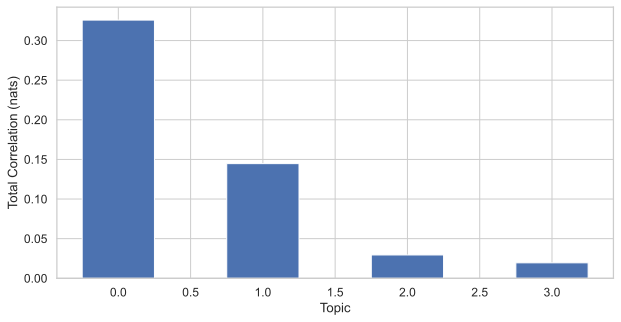

In [78]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, width=0.5);
plt.xlabel('Topic')
plt.ylabel('Total Correlation (nats)');

In [41]:
topic_model.get_top_docs(topic=3, n_docs=3, sort_by='tc')

[('La app es muy incredible me encanta es mi vida es como* me prestas El telefono para tik tok y es noo it would be like 🤯🤯* verdad hahahaha pero me encanta le puedes poner mucha emocion me quiero volver famosa y no puedo *triste* pero si me gusta por Los trends y Los bailes y me gusta la verdad es como que la tienen que descargar es muy Buena para tu aburimenteo Los bailes y Todo lo de mas Les va a encatar Les a a fasinar muchos dicen que no iluego me siguies en tiktok ahhaha asi Seria',
  32.754098106268984),
 ('Recomiendo esta app mucho ya que en cuarentena ha sido mi salvación, el para ti esta adaptado a lo que a ti te gustaría ver, y cuando entra a ese infinito para ti te llenas de creatividad en resumen muy buena app y la recomiendo muchísimo 🙂',
  30.74178239587549),
 ('Hola ,me encanta esta app, una actualizacion qué me gustaria que agregaran es para eliminar ruidos, yo muy poco grabo con la camara de ustedes porque cuando grabo debo utilizar una app para eliminar ruidos, por l

In [42]:
corex_2 = ct.Corex(n_hidden=4, words=words2)

In [43]:
corex_2.fit(bi_grams, words=words2, docs=no_null_reviews_df.review_text)

In [76]:
topics2 = corex_2.get_topics()
for n,topic in enumerate(topics2):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: people,time,make,watch,like,lot,friend,day,use,follower
1: viral,hai,meri,viral account,ko,kar,nhi,ho,unfreez,foryou
2: love,fun,funny,good love,love good,world,amazing love,love fun,love love,experience
3: good,nice,good like,good entertainment,good good,amazing,awesome,nice good,good application,super


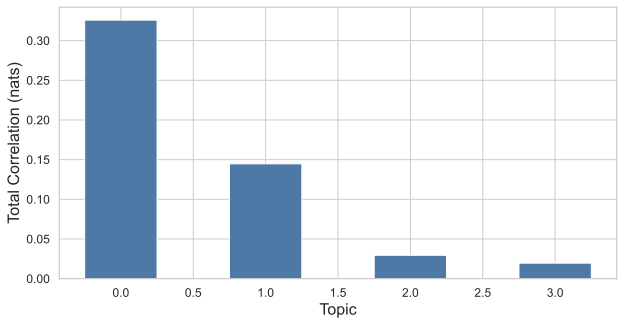

In [77]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [46]:
corex_2.get_top_docs(topic=0, n_docs=3, sort_by='tc')

[("The app itself used to be really good, all be it with a few minor bugs- \nhowever the recent update not only broke the already very confusing layout \n(for people just starting to use the app), but also screwed over existing \ncreators in several ways. All 'privates' that were saved to people's \naccounts have been removed/deleted and most if not all people were signed \nout of their respective accounts when reopening the app, some not being \nable to log back in. With all of the already negative attention the app was \nrecieving, this update has got to be some form of mistake, because any \ndeveloper with any sense of social awareness would know that bringing in \nchanges that would increase the amount of negativity towards their app, \nwould not be good for their business. These issues, however, would be \ntolerable if the musical.ly team had fixed the issues that their community \nwere very vocal about before this update, such as: -Better Android support \n-Fixing the tags -Bette

In [80]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = corex_2.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

NameError: name 'lda_model' is not defined